In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, UpSampling2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.datasets import cifar100
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

Using TensorFlow backend.


In [ ]:
batch_size = 64
epochs = 7
(x_train, y_train), (x_test, y_test) = cifar100.load_data()


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_val, y_val = x_train[40000:50000,:], y_train[40000:50000]
x_train, y_train = x_train[:50000,:], y_train[:50000]

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)


y_train = np_utils.to_categorical(y_train, 100)
y_val = np_utils.to_categorical(y_val, 100)
y_test = np_utils.to_categorical(y_test, 100)



169009152/169001437 [==============================] - 3s 0us/step


In [ ]:
filepath = '/kaggle/working/best_model_7.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

stop =  EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)


callbacks = [checkpoint, stop]

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(x_train)

resnet_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes = 100)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

234553344/234545216 [==============================] - 2s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

H = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(x_val, y_val),
                                  callbacks=callbacks)

Train for 781 steps, validate on 10000 samples
Epoch 1/7
780/781 [============================>.] - ETA: 0s - loss: 1.7697 - accuracy: 0.5402
Epoch 00001: val_accuracy improved from -inf to 0.74820, saving model to /kaggle/working/best_model_7.h5
781/781 [==============================] - 637s 816ms/step - loss: 1.7689 - accuracy: 0.5404 - val_loss: 0.8458 - val_accuracy: 0.7482
Epoch 2/7
780/781 [============================>.] - ETA: 0s - loss: 0.9526 - accuracy: 0.7206
Epoch 00002: val_accuracy improved from 0.74820 to 0.81050, saving model to /kaggle/working/best_model_7.h5
781/781 [==============================] - 611s 783ms/step - loss: 0.9526 - accuracy: 0.7206 - val_loss: 0.6189 - val_accuracy: 0.8105
Epoch 3/7
780/781 [============================>.] - ETA: 0s - loss: 0.7556 - accuracy: 0.7714
Epoch 00003: val_accuracy improved from 0.81050 to 0.84690, saving model to /kaggle/working/best_model_7.h5
781/781 [==============================] - 611s 782ms/step - loss: 0.7559 - a

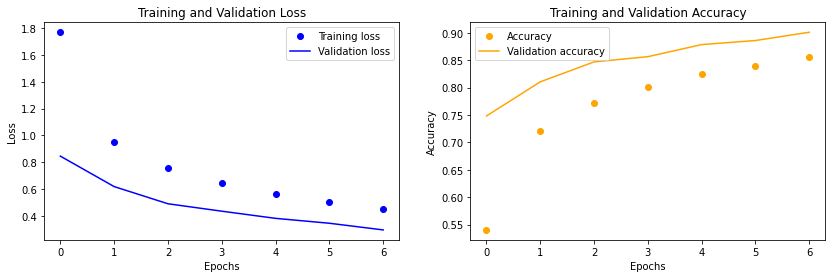

In [ ]:
numOfEpoch = epochs
plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], 'bo', label='Training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], 'bo', 
         label='Accuracy', c='orange')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], 'b', 
         label='Validation accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
scores = model.evaluate(x_test,
                        y_test,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.6229129084825515
Test accuracy: 0.8213


In [ ]:
from keras.models import load_model

model.save('my_model_7.h5')